## Basic python imports and model settings

In [2]:


import underworld.visualisation as vis

from underworld import function as fn
import underworld as uw

import matplotlib.pyplot as pyplot
import numpy as np
from scipy.spatial import distance

import math
import os
import sys

import time

from scipy.signal import savgol_filter

# deform the mesh geometry towards the ice-rock interface?
deform_mesh = False
perfect_mesh = True

# details of the bottom curve
L = [160, 80, 40, 20, 10, 5]

# make it command line compatible
if len(sys.argv):
    try:
        km_index = int(sys.argv[1])
    except:
        km_index = 5

i = km_index

maxX = L[i] * 1000.
min_bed_height = 500.           # we want a minimum of 500 m of rock beneath the ice
omega = 2.0 * np.pi / maxX
amplitude = 500.
average_bedthickness = 1000.
surface_height = average_bedthickness + amplitude + min_bed_height
maxY = surface_height

minY = minX = 0.

g = 9.81
ice_density = 910.

A = 1e-16
n = 3.

resX = 250
resY = 100

resX = 128
resY = 64

#resX = 48
#resY = 24

resX = 256
resY = 128

print("resX: " + str(resX) + " resY: " + str(resY))

# generate output path
outputPath = os.path.join(os.path.abspath("."), "output_" + str(maxX) + "_res_" + str(resX) + "_x_" + str(resY) + "/")

if not os.path.exists(outputPath):
    os.makedirs(outputPath)

os.chdir(outputPath)
    
delta_timestep = 1.						# in years, used in the main loop
# after how many timesteps do we need new figures?
update_figures_after_n_timesteps = 1
number_of_deformation_lines = 11

number_of_deformation_points = 50000
distance_between_deformation_lines = maxY / (number_of_deformation_lines + 1)

cell_height = maxY / resY
cell_width = maxX / resX


# # Mesh + mesh variables

resX: 256 resY: 128


In [3]:


elementType = "Q1/dQ0"
#elementType = "Q2/dQ1"
#elementType = "Q1/dPc1"
#elementType = "Q2/dPc1"

mesh = uw.mesh.FeMesh_Cartesian(elementType=(elementType),
                                elementRes=(resX, resY),
                                minCoord=(minX, minY),
                                maxCoord=(maxX, maxY),
                                periodic=[True, False])

submesh = mesh.subMesh

# save the mesh
# mesh.save(outputPath + "mesh.h5")

velocityField = uw.mesh.MeshVariable(mesh=mesh, nodeDofCount=mesh.dim)
#pressureField = uw.mesh.MeshVariable(mesh=mesh.subMesh, nodeDofCount=1)
pressureField = uw.mesh.MeshVariable(mesh=mesh, nodeDofCount=1)

viscosityField = uw.mesh.MeshVariable(mesh=mesh, nodeDofCount=1)

strainRateField = mesh.add_variable(nodeDofCount=1)

#pressureField.data[:] = 0.
velocityField.data[:] = [0., 0.]

# Initialise the 'materialVariable' data to represent different materials.
materialA = 0  	# accommodation layer, a.k.a. Sticky Air
materialV = 1  	# ice, isotropic
materialR = 2   # rock
materialT = 5   # test material in order to test eg interface detection

coord = fn.input()

z_bed_function = surface_height - average_bedthickness + amplitude * fn.math.sin(omega * coord[0])


# # Define the ice-rock / ice-air interface 

In [4]:


botSet = mesh.specialSets['Bottom_VertexSet']
topSet = mesh.specialSets['Top_VertexSet']

dx = (maxX - minX) / resX
iceRockInterface = []
iceAirInterface = []

dx = (maxX - minX) / resX

for index in range(resX+1):
    
    start_x = dx * index

    interface_y =  surface_height - average_bedthickness + amplitude * np.sin(start_x * (np.pi * 2.) / (maxX-minX) )
                
    #ind = np.where(abs(mesh.data[:,0] - start_x) < 0.01*dx)
    iceRockInterface.append([start_x, interface_y])
    iceAirInterface.append([start_x, maxY])


# # Deform mesh to be almost structurally conforming


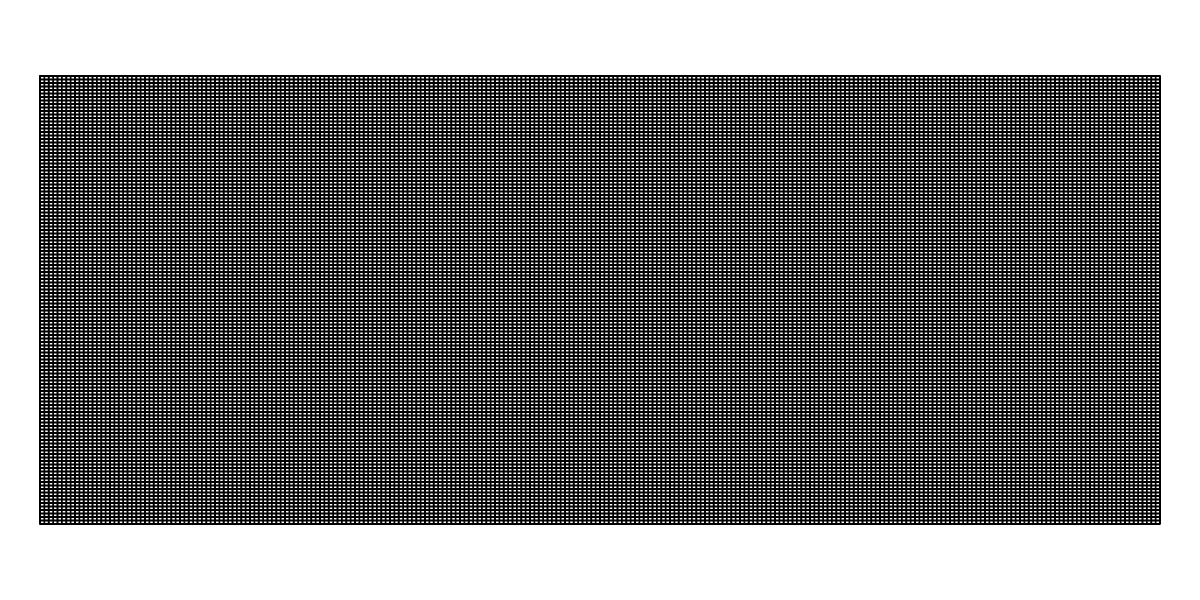

In [5]:


def mesh_deform(section,fixPoint,mi):
    
    # fixPoint: the position to be refined
    # mi: representing the gradient of mesh resolution; the larger mi, the larger gradient
    # generally, mi ranges from 0.1 to 3, dependnig on the resolution 
 
    # note from Till: 
    # I normalize it, because then it becomes more clear to me.
    # normalization is not strictly necessary
    normalize = maxY - minY

    section /= normalize
    fixPoint /= normalize

    for index in range(len(section)):
        
        maxCoord = np.max(section)
        minCoord = np.min(section)
        
        if  section[index] < fixPoint:
            zz_sqrt = (fixPoint - section[index])**mi
            zz_sqrt_max = (fixPoint - minCoord)**mi
            section[index] = fixPoint - (fixPoint - section[index]) * zz_sqrt / zz_sqrt_max

        if  section[index] > fixPoint:
            zz_sqrt = (section[index] - fixPoint)**mi
            zz_sqrt_max = (maxCoord - fixPoint)**mi
            section[index] = fixPoint + (section[index] - fixPoint) * zz_sqrt/zz_sqrt_max        
    
    return (section * normalize)

dx = (maxX - minX) / resX

if deform_mesh:
    
    with mesh.deform_mesh():

        for index in range(resX+1):  

            start_x = dx * index

            interface_y =  surface_height - average_bedthickness + amplitude * np.sin(start_x * (np.pi * 2.) / (maxX-minX) )

            #print (start_x,interface_y)
            #lx.append(start_x)
            #ly.append(interface_y)

            #ind = np.where(abs(mesh.data[:,0] - start_x) < 0.01*dx)
            ind = np.where(abs(mesh.data[:,0] - start_x) < 0.01*dx)

            mesh.data[ind[0],1] = mesh_deform(mesh.data[ind[0],1], interface_y, 0.25)

# visualise the result
figMesh = vis.Figure(figsize=(1200,600))
figMesh.append( vis.objects.Mesh(mesh) )
figMesh.save_image("mesh_postdeform.png")
figMesh.show()


# # Deform mesh to a perfect body fit mesh


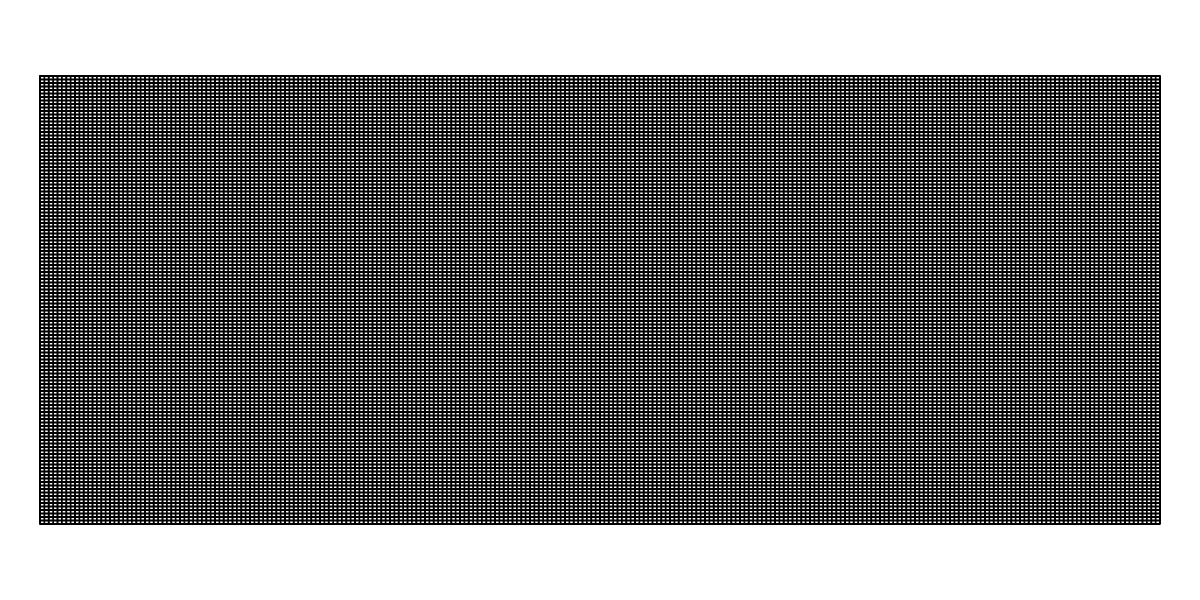


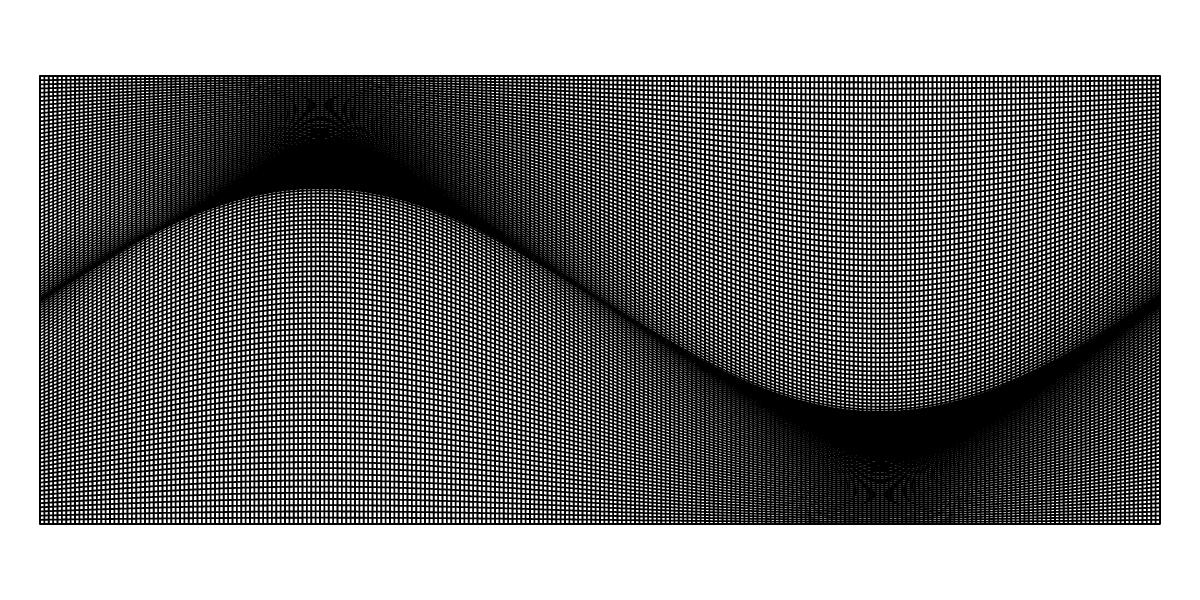

In [6]:


def mesh_deform_Ind(section,fixPoint_index,fixPoint,mi):
    
    section[int(fixPoint_index)] = fixPoint
    seqN = len(section)
    
    # fixPoint_index (int): specify the index of the section to be at the place need to be refined
    # fixPoint: the position to be refined
    # mi: representing the gradient of mesh resolution; the larger mi, the larger gradient
    for index in range(len(section)):
        
        maxCoord = np.max(section)
        minCoord = np.min(section)
        
        if  index < fixPoint_index:
            section[index] = minCoord + index*(fixPoint-minCoord)/fixPoint_index            
            zz_sqrt = (fixPoint-section[index])**mi
            zz_sqrt_max = (fixPoint-minCoord)**mi
            section[index] = fixPoint-(fixPoint-section[index])*zz_sqrt/zz_sqrt_max

        if  index > fixPoint_index:
            section[index] = fixPoint + (index-fixPoint_index)*(maxCoord-fixPoint)/(seqN-fixPoint_index-1)
            zz_sqrt = (section[index]-fixPoint)**mi
            zz_sqrt_max = (maxCoord-fixPoint)**mi
            section[index] =fixPoint+(section[index]-fixPoint)*zz_sqrt/zz_sqrt_max    
            
    return (section)

figMesh = vis.Figure(figsize=(1200,600))
figMesh.append( vis.objects.Mesh(mesh) )
figMesh.save_image("mesh_predeform.png")
figMesh.show()

#picswarm = uw.swarm.VoronoiIntegrationSwarm(swarm)
#picswarm.repopulate()

# visualise the result

if (perfect_mesh):
    
    with mesh.deform_mesh():
        
        for index in range(resX+1):  
            start_x = dx * index
            
            interface_y =  surface_height - average_bedthickness + amplitude * np.sin(start_x * (np.pi * 2.) / (maxX-minX) )
            
            ind = np.where(abs(mesh.data[:,0]-start_x)<0.01*dx)
            
            mesh.data[ind[0],1] = mesh_deform_Ind(mesh.data[ind[0],1],resY/2,interface_y,0.2)
    # make the swarm belong the element that is the same as the in the regular mesh
    
    # visualise the result
    figMesh = vis.Figure(figsize=(1200,600))
    figMesh.append( vis.objects.Mesh(mesh) )
    figMesh.save_image("mesh_deform_default_swarm.png")
    figMesh.show()
    
    #with swarm.deform_swarm():
        #swarm.particleCoordinates.data[:] = uw.function.input().evaluate(picswarm) 

        


# # Swarm

In [ ]:


part_per_cell = 50
swarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)

#swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout(swarm=swarm, particlesPerCell=part_per_cell)
swarmLayout = uw.swarm.layouts.PerCellGaussLayout( swarm=swarm, gaussPointCount=5 )

swarm.populate_using_layout(layout=swarmLayout)

measurementSwarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)

# create pop control object
pop_control1 = uw.swarm.PopulationControl(swarm, aggressive=True, particlesPerCell=part_per_cell)
pop_control2 = uw.swarm.PopulationControl(measurementSwarm)

# ### Create a particle advection system
#
# Note that we need to set up one advector systems for each particle swarm (our global swarm and a separate one if we add passive tracers).
advector1 = uw.systems.SwarmAdvector(swarm=swarm,velocityField=velocityField, order=2)
advector2 = uw.systems.SwarmAdvector(swarm=measurementSwarm,     velocityField=velocityField, order=2)

# Tracking different materials

materialVariable = swarm.add_variable(dataType="int", count=1)

numbMeasurementPoints = resX + 1
xloc = np.linspace(0, maxX, numbMeasurementPoints).reshape(-1,1)
yloc = (surface_height - average_bedthickness + amplitude * np.sin(omega * xloc)).reshape(-1,1)
xycoor = np.concatenate((xloc,yloc),axis = 1)

measurementSwarm.add_particles_with_coordinates(xycoor)

particleDensity = swarm.add_variable(dataType="double", count=1)
particleDensity.data[:] = 0.0

coord = fn.input()

conditions = [(coord[1] > surface_height, materialA),
              (coord[1] < z_bed_function, materialR),
              (True, materialV)]

materialVariable.data[:] = fn.branching.conditional(conditions).evaluate(swarm)

#pyplot.plot(measurementSwarm.data[:,0], measurementSwarm.data[:,1], color='black')

figMesh = vis.Figure(figsize=(1200,600))
figMesh.append( vis.objects.Mesh(mesh) )
figMesh.append( vis.objects.Points( swarm, materialVariable, pointSize=10.0 ) )
figMesh.save_image("mesh_deform.png")
figMesh.show()

In [ ]:


# find and index elements that contain mixed materials of materialA and materialB
ind1 = np.where(materialVariable.data[:]==materialV)
ind0 = np.where(materialVariable.data[:]==materialR)
index_common = np.intersect1d(swarm.owningCell.data[ind1[0]],swarm.owningCell.data[ind0[0]])
print (index_common)


# # Functions

# Viscosity function

In [ ]:


strainRateTensor = fn.tensor.symmetric(velocityField.fn_gradient)
strainRate_2ndInvariantFn = fn.tensor.second_invariant(strainRateTensor)

minViscosityIceFn = fn.misc.constant(1e+10 / 3.1536e7)
maxViscosityIceFn = fn.misc.constant(1e+15 / 3.1536e7)

viscosityFnAir = fn.misc.constant(1e6 / 3.1536e7)
viscosityFnRock = fn.misc.constant(1e22 / 3.1536e7)

viscosityFnIceBase = 0.5 * A ** (-1./n) * (strainRate_2ndInvariantFn**((1.-n) / float(n)))
viscosityFnIce = fn.misc.max(fn.misc.min(viscosityFnIceBase, maxViscosityIceFn), minViscosityIceFn)

viscosityMap = {
                materialV: viscosityFnIce,
                materialA: viscosityFnAir,
                materialR: viscosityFnRock,
               }

viscosityFn = fn.branching.map( fn_key=materialVariable, mapping=viscosityMap )

logViscosityFn = fn.math.log10( fn.misc.max( fn.misc.min( viscosityFnIceBase, viscosityFnRock ), viscosityFnAir ) )

devStressFn = 2.0 * viscosityFn * strainRateTensor
shearStressFn = strainRate_2ndInvariantFn * viscosityFn * 2.0

densityFnAir = fn.misc.constant( 0. )
densityFnIce = fn.misc.constant( ice_density )
densityFnRock = fn.misc.constant( 2700. )

densityMap = {
                materialA: densityFnAir,
                materialV: densityFnIce,
                materialR: densityFnRock
             }

densityFn = fn.branching.map(fn_key=materialVariable, mapping=densityMap)

particleDensity.data[:] = densityFn.evaluate(swarm)

surf_inclination = 0.5 * np.pi / 180. # 0.1 = Experiment D, 0.5 = Experiment B
#surf_inclination = 0.
z_hat = (math.sin(surf_inclination), - math.cos(surf_inclination))
#z_hat = (0.00872653549, -0.99996192306417128874)

buoyancyFn = densityFn * z_hat * 9.81


# Boundary conditions

In [ ]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
kWalls = mesh.specialSets["MinK_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]

base = mesh.specialSets["MinJ_VertexSet"]

# Surface points
top = mesh.specialSets["MaxJ_VertexSet"]

velocityField.data[:] = [0., 0.]

leftSet = mesh.specialSets['Left_VertexSet']
rightSet = mesh.specialSets['Right_VertexSet']

### Dirichlet
condition1 = uw.conditions.DirichletCondition(variable=velocityField,indexSetsPerDof=(botSet, botSet))

velocityField.data[:] = [0., 0.]


# Solver

In [ ]:
stokes = uw.systems.Stokes(
    velocityField=velocityField,
    pressureField=pressureField,
    voronoi_swarm=swarm,
    conditions=[
            condition1,
            ],
    fn_viscosity=viscosityFn,
    fn_bodyforce=buoyancyFn,
)

solver = uw.systems.Solver(stokes)

#solver.set_inner_method("lu")
#solver.set_inner_method("superlu")
solver.set_inner_method("mumps")
# solver.set_inner_method("superludist")
# solver.set_inner_method("mg")
#solver.set_inner_method("nomg")

# solver.set_penalty(1.0e10)  # higher penalty = larger stability
# solver.options.scr.ksp_rtol = 1.0e-3

# nl_tol = 2.e1
nl_tol = 5.e-3

surfaceArea = uw.utils.Integral( fn=1.0, mesh=mesh, integrationType='surface', surfaceIndexSet=top)
surfacePressureIntegral = uw.utils.Integral( fn=pressureField, mesh=mesh, integrationType='surface', surfaceIndexSet=top)

def calibrate_pressure():

    global pressureField
    global surfaceArea
    global surfacePressureIntegral

    (area,) = surfaceArea.evaluate()
    (p0,) = surfacePressureIntegral.evaluate() 
    pressureField.data[:] -= p0 / area

    print (f'Calibration pressure {p0 / area}')

# test it out
try:
    exec_time = time.time()
    # solver.solve(nonLinearIterate=True, nonLinearTolerance=nl_tol, callback_post_solve=calibrate_pressure)
    solver.solve(nonLinearIterate=True, callback_post_solve=calibrate_pressure)
    # solver.solve(nonLinearIterate=True)
    exec_time = time.time() - exec_time

    # print time to a file
    with open('../time.txt', 'a') as f:
        f.write('length,' + str(maxX) + ',x_res:,' + str(resX) + ',y_res:,' + str(resY) + ',time in secs:,' + str(exec_time) + '\n')
        
    # print full stats to a file
    original_stdout = sys.stdout # Save a reference to the original standard output
    
    with open('../stats_' + "output_" + str(maxX) + "_res_" + str(resX) + '_x_' + str(resY) + '.txt', 'w') as f:
        sys.stdout = f # Change the standard output to the file we created.
        solver.print_stats()
        sys.stdout = original_stdout # Reset the standard output to its original value
        
    solver.print_stats()
except:
    print("Solver died early..")
    exit(0)


# Write out surface data

In [ ]:
# Surface points
top = mesh.specialSets["MaxJ_VertexSet"]

# save to disc
outputPath = "test/"
#?os.makedirs(outputPath)
outputFile = os.path.join(os.path.abspath("."), outputPath + "output.csv")

####
iceAirInterface = mesh.specialSets["MaxJ_VertexSet"]

vx = []

for i in iceAirInterface:
    vx.append(velocityField.evaluate(mesh.data[i][0], mesh.data[i][1], mesh.data[i][2]))

#coordinaten: mesh.data[i][0]

with open(outputFile, "w") as text_file:

    text_file.write("X," + "Y," + "Z," + "surf vx," + "surf vy," + "surf vz" + "\n")
    
    for i in range(0,len(interfacex)):
        textline = .... str(velocityField.evaluate((mesh.data[i][0], mesh.data[i][1], mesh.data[i][2]))[0][0]) + "," + "\n"
        text_file.write(textline)

In [ ]:
# plot saved files

# visualize vector fields (eg velocity) with pyplot.quiver: 
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.quiver.html

print ("topo")
pyplot.scatter (a[0], a[1])
#pyplot.plot(a[0], yhat, color='red')
pyplot.show()
#pyplot.savefig("topo.png")